# Projet 8 : Déployer un modèle dans le Cloud


# 1 - Project presentation

Fruits is a start-up that wants to make itself known by making available to the general public a mobile application that would allow users to take a picture of a fruit and obtain information about this fruit.

For the start-up, this application would make the general public aware of fruit biodiversity and set up a first version of the fruit image classification engine.
The objective of this project is to develop a Big Data environment that will include preprocessing and a dimension reduction step.

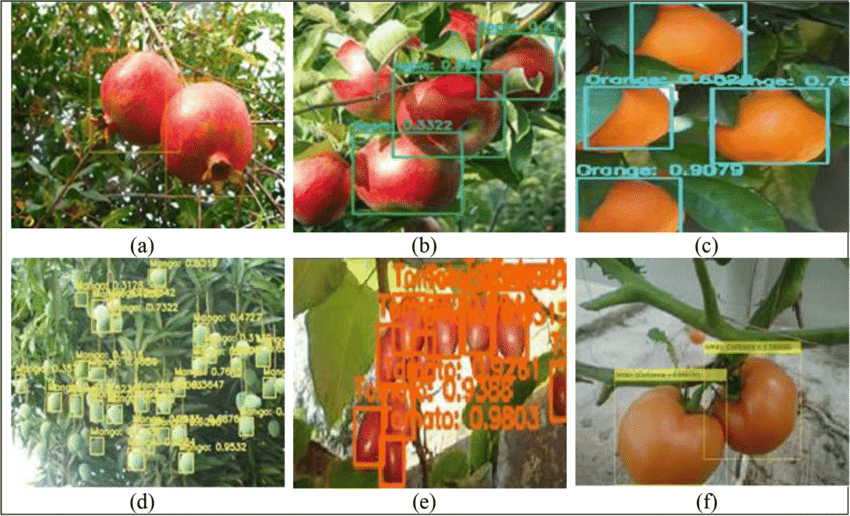

# 2 - Load Packages

In [1]:
#to use spark within a jupyter notebook
import findspark
findspark.init()
#
import pandas as pd
from PIL import Image
import numpy as np
import time
import io
import os
import warnings
warnings.filterwarnings('ignore')
import boto3
from typing import Iterator

#
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
#
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, lit, udf
from pyspark.ml.feature import PCA, StandardScaler, VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import ArrayType, StringType



2022-09-15 13:51:46.442631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 13:51:46.665390: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-15 13:51:46.665452: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-15 13:51:46.703133: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-15 13:51:47.550612: W tensorflow/stream_executor/platform/de

# 3 -  Instanciation spark session & configuration

In [2]:
# Sparksession instantiation
spark = SparkSession.builder.appName("Fruits_Vegetables_recognition").getOrCreate()
#To create a sparkContext
sc = spark.sparkContext
sc.setLogLevel("WARN")
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/15 13:51:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# AWS access configuration
credential = pd.read_csv("../p8_user_credentials.csv")
ID = credential["Access key ID"][0]
KEY = credential["Secret access key"][0]

In [4]:
# Hadoop configuration
spark._jsc.hadoopConfiguration().set("fs.s3a.impl", "org.apache.hadoop.fs.s3native.NativeS3FileSystem")
spark._jsc.hadoopConfiguration().set("fs.s3a.access.key",ID)
spark._jsc.hadoopConfiguration().set("fs.s3a.secret.key",KEY)
spark._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3-eu-west-3.amazonaws.com")
spark._jsc.hadoopConfiguration().set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")

# 4 -  Functions 

## 4 - 1 - Load images and categories functions 

In [5]:
def parse_category(BUCKET):
    
    """
    To parse fruit categories repository
    args : 
        folder:
    return : a list of fruit categories folder
    """
    session = boto3.session.Session(aws_access_key_id=ID, aws_secret_access_key=KEY)
    s3_client = session.client(service_name='s3', region_name="eu-west-3")
    
    lst_category = set()  #Using a set removes duplicates automatically 
    for key in s3_client.list_objects(Bucket=BUCKET)['Contents']:
        lst_category.add(key["Key"].split("/")[1])  #Here we only keep the first level of the key 
    lst_category = list(lst_category)
        
    return lst_category


def load_fruit_cat(folder, category):
    """
    To read images of a fruit category at once using spark
    args : 
        category : fruit category
    return:
        pyspark dataframe containing all images of one category of fruits
    
    """
    
    fruit_cat = spark.read.format("binaryFile")\
    .option("pathGlobFilter", "*.jpg")\
    .option("recursiveFileLookup", "true")\
    .load(folder + "/" + category)\
    .withColumn("fruit_category", lit(category.lower()))   
    
    return fruit_cat


def load_images(folder, lst_category):
    """
    To read all images for all fruits categories
    args: 
        categories : all categories of fruits
    return:
        cat_img : pyspark dataframe that contains paths of all fruits
    
    """
    for i, category in enumerate(lst_category):
        if i==0:
            cat_img = load_fruit_cat(folder, category)
        else:
            image = load_fruit_cat(folder, category)
            cat_img = cat_img.union(image)
            
    return cat_img            



## 4 - 2 - Images featurization functions - Transfer learning

In [6]:
def model_fn():
    """
     Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
     """
    model = ResNet50(weights=None, include_top=False)
    model.set_weights(bc_model_weights.value)
    
    return model
    
    
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    
    img = Image.open(io.BytesIO(content)).resize([20, 20])
    arr = img_to_array(img)
    return preprocess_input(arr)


def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    
    return pd.Series(output)

@pandas_udf('array<float>')
def featurize_udf(content : Iterator[pd.Series]) -> Iterator[pd.Series]:
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                                is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content:
        yield featurize_series(model, content_series)



# 5 - Main program execution

In [7]:
# Name of S3 bucket
BUCKET = "projet8sabrine"
#To define path floder of images
folder = "s3a://projet8sabrine/Training/" 
# List of fruits categories folders
lst_category = parse_category(BUCKET)
print("{} categories of fruits are Downloaded.\n".format(len(lst_category)))
# List of paths of all images

print("-------------Images list & categories download-----------\n")
t0 = time.time()    
images = load_images(folder, lst_category)
print(images.count(), "images of different kinds of fruits were downloaded.\n")
images.show()
print("Download time :", time.time()-t0,"seconds")

    
print("-------------Features extraction------------\n") 
#To create the model and remove the last layer
model = ResNet50(include_top=False)
bc_model_weights = sc.broadcast(model.get_weights())

# Pandas UDFs on large records (e.g., very large images) can run into Out Of Memory (OOM) errors.
# If you hit such errors in the cell below, try reducing the Arrow batch size via `maxRecordsPerBatch`.
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

# We can now run featurization on our entire Spark DataFrame.
# NOTE: This can take a long time (about 10 minutes) since it applies a large model to the full dataset.
t0 = time.time()    
features_df = images.select(col("path"), featurize_udf("content").alias("features"), "fruit_category")
features_df.show()
print("Features extraction time :", time.time()-t0,"seconds")



3 categories of fruits are Downloaded.

-------------Images list & categories download-----------

22/09/15 13:51:55 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


1474 images of different kinds of fruits were downloaded.



+--------------------+-------------------+------+--------------------+--------------+
|                path|   modificationTime|length|             content|fruit_category|
+--------------------+-------------------+------+--------------------+--------------+
|s3a://projet8sabr...|2022-09-07 16:07:48|  4992|[FF D8 FF E0 00 1...|          pear|
|s3a://projet8sabr...|2022-09-07 16:07:48|  4976|[FF D8 FF E0 00 1...|          pear|
|s3a://projet8sabr...|2022-09-07 16:07:48|  4971|[FF D8 FF E0 00 1...|          pear|
|s3a://projet8sabr...|2022-09-07 16:07:51|  4963|[FF D8 FF E0 00 1...|          pear|
|s3a://projet8sabr...|2022-09-07 16:07:51|  4961|[FF D8 FF E0 00 1...|          pear|
|s3a://projet8sabr...|2022-09-07 16:07:49|  4960|[FF D8 FF E0 00 1...|          pear|
|s3a://projet8sabr...|2022-09-07 16:07:50|  4958|[FF D8 FF E0 00 1...|          pear|
|s3a://projet8sabr...|2022-09-07 16:07:49|  4957|[FF D8 FF E0 00 1...|          pear|
|s3a://projet8sabr...|2022-09-07 16:07:49|  4949|[FF D

2022-09-15 13:52:15.989629: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-15 13:52:15.989688: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-15 13:52:15.989718: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-44-243): /proc/driver/nvidia/version does not exist
2022-09-15 13:52:15.989982: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 13:52:22.607871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is

+--------------------+--------------------+--------------+
|                path|            features|fruit_category|
+--------------------+--------------------+--------------+
|s3a://projet8sabr...|[0.361879, 7.7340...|          pear|
|s3a://projet8sabr...|[0.4407841, 7.681...|          pear|
|s3a://projet8sabr...|[0.3895508, 7.759...|          pear|
|s3a://projet8sabr...|[0.16384494, 7.32...|          pear|
|s3a://projet8sabr...|[0.17961597, 7.39...|          pear|
|s3a://projet8sabr...|[0.3476231, 7.481...|          pear|
|s3a://projet8sabr...|[0.21078455, 7.46...|          pear|
|s3a://projet8sabr...|[0.36153495, 7.34...|          pear|
|s3a://projet8sabr...|[0.35935462, 7.50...|          pear|
|s3a://projet8sabr...|[0.24008846, 7.30...|          pear|
|s3a://projet8sabr...|[0.44012558, 7.81...|          pear|
|s3a://projet8sabr...|[0.22529626, 7.24...|          pear|
|s3a://projet8sabr...|[0.04088807, 7.98...|          pear|
|s3a://projet8sabr...|[0.020971656, 8.1...|          pea

# 6 - Save images output

## 6 - 1 - Parquet format

In [8]:
print("-------------Save results(parquet format------------\n")
t0 = time.time()    
features_df.write.mode("overwrite").parquet("s3a://" + BUCKET + "/parquet/fruits_result.parquet")
print("Save time :", time.time()-t0,"seconds")   
print("saving done")


-------------Save results(parquet format------------

Save time : 5.1975250244140625e-05 seconds


2022-09-15 13:52:31.876661: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 13:52:32.120415: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-15 13:52:32.121115: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-15 13:52:32.159076: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-15 13:52:32.382700: I tensorflow/core/platform/cpu_feature_g

1/1 [==============================] - 1s 1s/step


saving done


In [9]:
# Read spark parquet
parq_img = spark.read.parquet("s3a://" + BUCKET + "/parquet/fruits_result.parquet")
parq_img.show()

+--------------------+--------------------+--------------+
|                path|            features|fruit_category|
+--------------------+--------------------+--------------+
|s3a://projet8sabr...|[0.361879, 7.7340...|          pear|
|s3a://projet8sabr...|[0.4407841, 7.681...|          pear|
|s3a://projet8sabr...|[0.3895508, 7.759...|          pear|
|s3a://projet8sabr...|[0.16384494, 7.32...|          pear|
|s3a://projet8sabr...|[0.17961597, 7.39...|          pear|
|s3a://projet8sabr...|[0.3476231, 7.481...|          pear|
|s3a://projet8sabr...|[0.21078455, 7.46...|          pear|
|s3a://projet8sabr...|[0.36153495, 7.34...|          pear|
|s3a://projet8sabr...|[0.35935462, 7.50...|          pear|
|s3a://projet8sabr...|[0.24008846, 7.30...|          pear|
|s3a://projet8sabr...|[0.44012558, 7.81...|          pear|
|s3a://projet8sabr...|[0.22529626, 7.24...|          pear|
|s3a://projet8sabr...|[0.04088807, 7.98...|          pear|
|s3a://projet8sabr...|[0.020971656, 8.1...|          pea

## 6 - 2 - CSV format

In [10]:
# 
def array_to_string(my_list):
    """
    To convert array column to string to enable saving in csv format
    """
    return '[' + ','.join([str(elem) for elem in my_list]) + ']'

array_to_string_udf = udf(array_to_string, StringType())
df = features_df.withColumn('features_as_str', array_to_string_udf(features_df["features"]))
df = df.drop("features")
df.printSchema

<bound method DataFrame.printSchema of DataFrame[path: string, fruit_category: string, features_as_str: string]>

In [12]:
print("-------------Save results(csv format------------\n")
t0 = time.time()    
df.write.option("header","true").mode("overwrite").csv("s3a://" + BUCKET + "/csv/fruits_features.csv")
print("Save time :", time.time()-t0,"seconds")   
print("saving done")

-------------Save results(csv format------------

22/09/15 13:55:23 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.
22/09/15 13:55:23 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.
22/09/15 13:55:23 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step


22/09/15 13:55:29 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.
22/09/15 13:55:29 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


2022-09-15 13:55:32.071933: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 13:55:32.325643: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-15 13:55:32.326271: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-15 13:55:32.369230: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-15 13:55:33.253328: W tensorflow/stream_executor/platform/de

22/09/15 13:55:35 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step                  (3 + 2) / 48]


22/09/15 13:55:40 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step                  (4 + 2) / 48]


22/09/15 13:55:41 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step                  (5 + 2) / 48]


22/09/15 13:55:45 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step                  (6 + 2) / 48]


22/09/15 13:55:47 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step                  (7 + 2) / 48]


22/09/15 13:55:51 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step


22/09/15 13:55:53 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step                  (9 + 2) / 48]


22/09/15 13:55:56 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step                 (10 + 2) / 48]


22/09/15 13:55:58 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step


22/09/15 13:56:02 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step                 (12 + 2) / 48]


22/09/15 13:56:04 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step


22/09/15 13:56:07 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step                 (14 + 2) / 48]


22/09/15 13:56:09 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step


22/09/15 13:56:12 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step                 (16 + 2) / 48]


22/09/15 13:56:15 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step                 (17 + 2) / 48]


22/09/15 13:56:18 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step


22/09/15 13:56:21 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step


22/09/15 13:56:23 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step                 (20 + 2) / 48]


22/09/15 13:56:26 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step                 (21 + 2) / 48]


22/09/15 13:56:29 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step                 (22 + 2) / 48]


22/09/15 13:56:31 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step                 (23 + 2) / 48]


22/09/15 13:56:35 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step                 (24 + 2) / 48]


22/09/15 13:56:37 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step


22/09/15 13:56:40 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step


22/09/15 13:56:42 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step


22/09/15 13:56:46 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step                 (28 + 2) / 48]


22/09/15 13:56:48 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step


22/09/15 13:56:51 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step


22/09/15 13:56:54 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step                 (31 + 2) / 48]


22/09/15 13:56:55 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step                 (32 + 2) / 48]


22/09/15 13:56:59 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step                 (33 + 2) / 48]


22/09/15 13:57:01 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step>                (34 + 2) / 48]


22/09/15 13:57:05 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step=>               (35 + 2) / 48]


22/09/15 13:57:07 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step==>              (36 + 2) / 48]


22/09/15 13:57:11 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step===>             (37 + 2) / 48]


22/09/15 13:57:13 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step=====>           (38 + 2) / 48]


22/09/15 13:57:16 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step======>          (39 + 2) / 48]


22/09/15 13:57:19 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step=======>         (40 + 2) / 48]


22/09/15 13:57:22 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step


22/09/15 13:57:25 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step=========>       (42 + 2) / 48]


22/09/15 13:57:27 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step


22/09/15 13:57:30 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step============>    (44 + 2) / 48]


22/09/15 13:57:33 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step=============>   (45 + 2) / 48]


22/09/15 13:57:35 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


1/1 [==============================] - 1s 1s/step===============> (47 + 1) / 48]


saving done


In [13]:
csv_img = spark.read.option("header","true").csv("s3a://" + BUCKET + "/csv/fruits_features.csv")
csv_img.show()

+--------------------+--------------+--------------------+
|                path|fruit_category|     features_as_str|
+--------------------+--------------+--------------------+
|s3a://projet8sabr...|          pear|[0.36187899112701...|
|s3a://projet8sabr...|          pear|[0.44078409671783...|
|s3a://projet8sabr...|          pear|[0.38955080509185...|
|s3a://projet8sabr...|          pear|[0.16384494304656...|
|s3a://projet8sabr...|          pear|[0.17961597442626...|
|s3a://projet8sabr...|          pear|[0.34762310981750...|
|s3a://projet8sabr...|          pear|[0.21078455448150...|
|s3a://projet8sabr...|          pear|[0.36153495311737...|
|s3a://projet8sabr...|          pear|[0.35935461521148...|
|s3a://projet8sabr...|          pear|[0.24008846282958...|
|s3a://projet8sabr...|          pear|[0.44012558460235...|
|s3a://projet8sabr...|          pear|[0.22529625892639...|
|s3a://projet8sabr...|          pear|[0.04088807106018...|
|s3a://projet8sabr...|          pear|[0.02097165584564..